In [ ]:
# AST 384C - Computational Astrophysics - HW 1
## Carlos Jurado

In [2]:
# Python package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import timeit
from tqdm import tqdm
import time

# Loading in style file for plots
plt.style.use('/Users/caj3577/Desktop/plotting.mplstyle')

## Problem 1: 

Can LLMs replace you (or at least, your answers to homework problems)?

Using the AI of your choice (e.g. Chat-GPT, Claude, etc.), redo the following problems:

• HW1, problem 2 (generating the positions & velocities), no need to do efficiency tests

• HW2, problem 1 (4th-order RK for Kepler problem) with e =0.96

• Hogg & Foreman-Mackey, problem 2 (M-H algorithm with a Gaussian likelihood)

In each case, describe how easy (or hard) it was to get the LLM to give a solution, whether
the initial solution was right, and discuss how it compares to your solution. Can AI replace
your brain for doing HW? If so, for what kinds of problems?

#### Redoing HW1, Problem 1 With ChatGPT

In [ ]:
# ============================
# Hernquist Profile Parameters
# ============================

# Physical constants
G = 4.302e-6  # gravitational constant in (kpc * km^2)/(Msun * s^2)

# Halo properties
M = 1e12  # total mass in Msun
a = 35.0  # scale length in kpc
N = 10**6  # number of particles

# ============================
# Functions
# ============================

def hernquist_potential(r):
    """
    Gravitational potential at radius r for the Hernquist profile.
    Φ(r) = - G M / (r + a)
    """
    return -G * M / (r + a)

def hernquist_density(r):
    """
    Density profile of the Hernquist model.
    ρ(r) = (M / 2π) * (a / r) * 1/(r + a)^3
    """
    return (M / (2 * np.pi)) * (a / r) / (r + a)**3

def hernquist_mass(r):
    """
    Enclosed mass as a function of radius.
    M(r) = M * r^2 / (r + a)^2
    """
    return M * r**2 / (r + a)**2

def f_E(E):
    """
    Approximate Hernquist distribution function f(E)
    Using analytic form from Hernquist (1990), Eq. 17.
    E must be positive (bound).
    """
    # Dimensionless energy
    q = E / (-hernquist_potential(0))  # E divided by central potential
    if np.any(q < 0) or np.any(q > 1):
        return 0
    return (1 / (np.sqrt(2) * np.pi**3 * (G * M * a)**1.5)) * (
        1 / (1 - q)**2.5 - (6 * q) / (1 - q)**3.5 + (6 * q**2) / (1 - q)**4.5
    )

def sample_radius(N):
    """
    Sample N radii according to the Hernquist cumulative mass distribution.
    We invert M(r)/M = X to get r(X).
    """
    X = np.random.uniform(0, 1, N)
    r = a * X**2 / (1 - X**2)
    return r

def sample_velocity(r):
    """
    Sample a velocity magnitude at a given radius r using the acceptance-rejection method.
    """
    phi_r = hernquist_potential(r)
    vmax = np.sqrt(2 * (0 - phi_r))  # Escape velocity

    while True:
        v = np.random.uniform(0, vmax)
        E = phi_r - 0.5 * v**2  # Binding energy
        if E <= 0:
            continue  # Only sample bound particles
        p_accept = f_E(E) * v**2
        p_trial = np.random.uniform(0, 1) * f_E(phi_r) * vmax**2  # max f(E) * v^2 at E = phi(r)
        if p_trial < p_accept:
            return v

def random_unit_vector(N):
    """
    Generate N random unit vectors.
    """
    phi = np.random.uniform(0, 2*np.pi, N)
    costheta = np.random.uniform(-1, 1, N)
    sintheta = np.sqrt(1 - costheta**2)

    x = sintheta * np.cos(phi)
    y = sintheta * np.sin(phi)
    z = costheta
    return np.vstack((x, y, z)).T

# ============================
# Main Code
# ============================


# Step 1: Sample particle positions
radii = sample_radius(N)  # radial distances
directions = random_unit_vector(N)  # unit vectors

positions = (radii[:, np.newaxis]) * directions  # shape (N, 3)

# Step 2: Sample particle velocities with progress bar
velocities = np.zeros((N, 3))
print("Sampling velocities...")
for i in tqdm(range(N)):
    v_mag = sample_velocity(radii[i])
    vel_dir = random_unit_vector(1)[0]  # a random 3D direction
    velocities[i] = v_mag * vel_dir

# ============================
# Test: Velocity dispersion profile
# ============================

# Compute radial velocities
rhat = positions / np.linalg.norm(positions, axis=1)[:, np.newaxis]
v_radial = np.sum(velocities * rhat, axis=1)

# Bin particles in radial bins
r_bins = np.logspace(np.log10(np.min(radii)), np.log10(np.max(radii)), 30)
r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])

v_dispersion = []
for i in range(len(r_bins) - 1):
    mask = (radii >= r_bins[i]) & (radii < r_bins[i+1])
    if np.sum(mask) > 0:
        v_dispersion.append(np.std(v_radial[mask]))
    else:
        v_dispersion.append(np.nan)

# Expected theoretical velocity dispersion (Eq. 10 of Hernquist 1990)
def theoretical_sigma_r(r):
    term1 = G * M * r
    term2 = 12 * (r + a)**3
    term3 = np.log((r + a)/r) - (a/(r+a))*(1 + 2*r/a - 6*(r/(r+a)) + (r/a)*(r/(r+a)))
    return np.sqrt(term1 / term2 * term3)

r_theory = np.logspace(np.log10(np.min(radii)), np.log10(np.max(radii)), 100)
sigma_r_theory = theoretical_sigma_r(r_theory)

# Plot
plt.figure(figsize=(8,6))
plt.loglog(r_centers, v_dispersion, 'o', label='Simulated')
plt.loglog(r_theory, sigma_r_theory, '-', label='Theory (Hernquist)')
plt.xlabel('r [kpc]')
plt.ylabel('Radial Velocity Dispersion [km/s]')
plt.legend()
plt.title('Radial Velocity Dispersion Profile')
plt.grid(True)
plt.show()


I start the ChatGPT prompt by asking it to write me a functional python code with thorough usage of comments that answers the prompt. I then paste the homework prompt.    

#### Redoing HW2, Problem 1 With ChatGPT

In [ ]:
# Constants
G = 1.0  # Gravitational constant, normalized for solar mass and AU
M = 1.0  # Mass of the central body (1 M⊙)
a = 1.0  # Semi-major axis in AU
e = 0.96  # Eccentricity

# Calculate rp and vp from the given equations
rp = a * (1 - e)  # Pericenter distance
vp = np.sqrt(G * M / a * (1 + e) / (1 - e))  # Pericenter velocity

# Initial conditions
r0 = np.array([rp, 0])  # Position at pericenter (x, y)
v0 = np.array([0, -vp])  # Velocity at pericenter (vx, vy)
y0 = np.concatenate((r0, v0))  # Initial state [x, y, vx, vy]

# Time parameters
T = 1  # Period in years (for a circular orbit, period is 2π for this system)
num_steps = 365  # Number of steps (1 step per day for 1 year)
dt = T / num_steps  # Time step (1 day)
t_values = np.linspace(0, T, num_steps)

# Define the system of equations: r_dot = v, v_dot = -GM / r^3 * r
def kepler_rhs(t, y):
    r = y[:2]
    v = y[2:]
    r_mag = np.linalg.norm(r)
    
    # Acceleration due to gravity
    a = -G * M / r_mag**3 * r
    
    return np.concatenate((v, a))

# 4th-order Runge-Kutta solver
def runge_kutta_4th_order(f, y0, t0, tf, dt):
    times = np.arange(t0, tf, dt)
    y = np.zeros((len(times), len(y0)))
    y[0] = y0
    
    for i in range(1, len(times)):
        t = times[i-1]
        y_current = y[i-1]
        
        k1 = f(t, y_current)
        k2 = f(t + dt/2, y_current + dt/2 * k1)
        k3 = f(t + dt/2, y_current + dt/2 * k2)
        k4 = f(t + dt, y_current + dt * k3)
        
        y[i] = y_current + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return times, y

# Solve the system using Runge-Kutta
times, solution = runge_kutta_4th_order(kepler_rhs, y0, 0, T, dt)

# Extract position and velocity
positions = solution[:, :2]
velocities = solution[:, 2:]

# Plot the orbit
plt.figure(figsize=(6, 6))
plt.plot(positions[:, 0], positions[:, 1], label='Orbit')
plt.scatter([0], [0], color='red', label='Central Body')
plt.title("Orbit for e = 0.96 using Runge-Kutta")
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.axis('equal')
plt.legend()
plt.show()


Redoing Hogg & Foreman-Mackey, problem 2 (M-H algorithm with a Gaussian likelihood) With ChatGPT

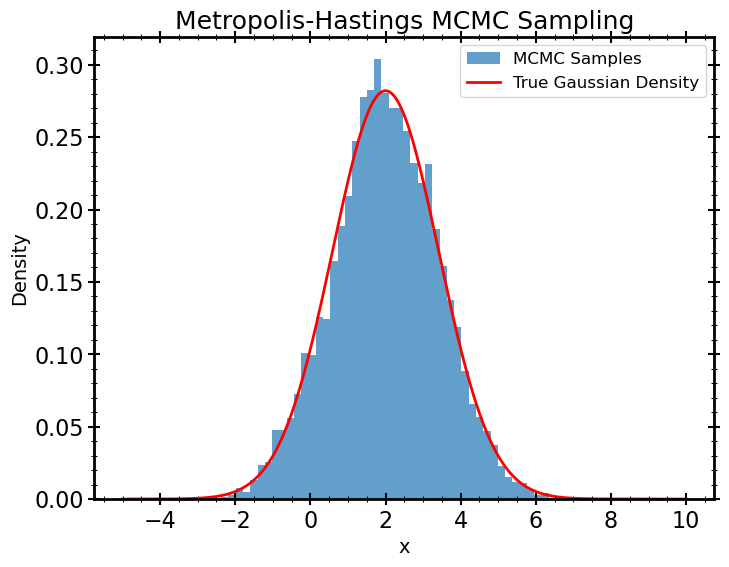

In [3]:
# Define the target density function p(x), which is a Gaussian with mean 2 and variance 2
def target_density(x, mean=2, variance=2):
    """
    Calculates the probability density of a Gaussian distribution.
    :param x: The point at which to evaluate the density.
    :param mean: The mean of the Gaussian distribution (default is 2).
    :param variance: The variance of the Gaussian distribution (default is 2).
    :return: The probability density of x.
    """
    return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * ((x - mean) ** 2) / variance)

# Define the proposal distribution q(x'|x), which is a Gaussian centered at x with variance 1
def proposal_distribution(x, proposal_variance=1):
    """
    Generates a proposal value x' from a Gaussian distribution with mean x and variance 1.
    :param x: The current value of x.
    :param proposal_variance: The variance of the proposal distribution (default is 1).
    :return: A proposed new value x'.
    """
    return np.random.normal(x, np.sqrt(proposal_variance))

# Metropolis-Hastings MCMC Sampler
def metropolis_hastings_sampler(n_steps, initial_x=0, proposal_variance=1, target_mean=2, target_variance=2):
    """
    Runs the Metropolis-Hastings MCMC sampler to sample from a Gaussian distribution.
    :param n_steps: The number of steps to run the sampler.
    :param initial_x: The initial value of x for the sampler (default is 0).
    :param proposal_variance: The variance of the proposal distribution (default is 1).
    :param target_mean: The mean of the target Gaussian distribution (default is 2).
    :param target_variance: The variance of the target Gaussian distribution (default is 2).
    :return: An array of sampled values.
    """
    # Initialize the array to store samples
    samples = np.zeros(n_steps)
    # Set the initial sample
    samples[0] = initial_x

    for i in range(1, n_steps):
        # Propose a new value using the proposal distribution
        proposed_x = proposal_distribution(samples[i - 1], proposal_variance)
        
        # Calculate the acceptance ratio
        acceptance_ratio = target_density(proposed_x, target_mean, target_variance) / target_density(samples[i - 1], target_mean, target_variance)
        
        # Accept or reject the proposal based on the acceptance ratio
        if np.random.uniform(0, 1) < acceptance_ratio:
            samples[i] = proposed_x  # Accept the proposed value
        else:
            samples[i] = samples[i - 1]  # Reject the proposal and keep the current value

    return samples

# Set up the sampler parameters
n_steps = 10000  # Number of MCMC steps
initial_x = 0    # Initial value of x

# Run the MCMC sampler
samples = metropolis_hastings_sampler(n_steps, initial_x)

# Plot the histogram of the samples
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, label='MCMC Samples')

# Plot the true target Gaussian density over the histogram
x_vals = np.linspace(-5, 10, 1000)
true_density = target_density(x_vals)
plt.plot(x_vals, true_density, label='True Gaussian Density', color='red', linewidth=2)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings MCMC Sampling')
plt.legend()
plt.show()
